# 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [272]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# for flattening tuples and lists
from itertools import chain
from itertools import islice

from tqdm import tqdm
import os
import random
import pickle
import multiprocessing

#import own modules
import balancing_workflow as bw


In [163]:
#(implement elsewhere, zenodo file maybe?) load GDB13S 
with open('/home/yves/Documents/GitHub/ReactionClasses/16_02_23/GDB/13S.smi', 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

#load formatted template dataframe
#temp_r0 = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/amol_USPTO_templates_set_r0_v2_formatted.pkl')

#load df_templates prepared in (*)
df_templates = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich.pkl')

#load GDB13S_mol (3%) prepared in (*)
#with open('./data/GDB13S_003perc_mol.pkl', 'rb') as f:
#    GDB13S_mol = pickle.load(f)

# (*) 1. Data preparation

df_template

In [6]:
#(*)
#retrieve list of templates to work on
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(temp_r0['template_hash'])

In [5]:
#(*)
#create a dataframe to store the enrichment information

df_templates = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates['template_hash'] = templates_to_enrich
df_templates['frequency'] = templates_to_enrich_appearances
df_templates['retro_templates'] = [bw.find_reaction_template_of_hash(temp_r0, templates_to_enrich[i]) for i in range(len(templates_to_enrich))] #3 min
df_templates['retro_reac'] = [Chem.MolToSmiles(bw.rxn_smarts_to_sanitized_reactant_smarts(df_templates.at[i, 'retro_templates'])) for i in range(len(df_templates))]


In [6]:
#(*)
#save df_templates to pickle 
df_templates.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich.pkl')

df_template_beckmann preparation

In [243]:
Beckmanndf = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/Beckmann_2rxns.pkl')


In [252]:
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(Beckmanndf['template_hash'], min_number = 1, target_number = 10000)

df_templates_Beckmann = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates_Beckmann['template_hash'] = templates_to_enrich
df_templates_Beckmann['frequency'] = templates_to_enrich_appearances
df_templates_Beckmann['retro_templates'] = [bw.find_reaction_template_of_hash(Beckmanndf, templates_to_enrich[i]) for i in range(len(templates_to_enrich))] #3 min


In [262]:
#save to reload later
df_templates_Beckmann.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')

GDB13S_mol version

In [ ]:
#choose a subset of GDB13S ~3M SMILES
random.seed(42)
GDB13S = random.sample(GDB13S,round(0.03*len(GDB13S)))

#convert SMILES to RDKit mol format
from multiprocessing import Pool

dataset = GDB13S
processes = os.cpu_count()-2

def MolFromSmiles(smi):
    return Chem.MolFromSmiles(smi)

if __name__ == '__main__':
   with Pool(processes) as p:
      output = list(tqdm(p.imap(MolFromSmiles, dataset), total = len(dataset)))

GDB13S_mol = output
del output, dataset

with open('./data/GDB13S_003perc_mol.pkl', 'wb') as f:
    pickle.dump(GDB13S_mol, f)

# 2. Framework dev

## 2.1 Prepare data to run all templates on a single portion of GDB13S

In [300]:
#after loading GDB13S (full) and df_templates (full)

#1. select a short enough part of GDB13S and save both the SMILES and the mol format

fraction = 0.01 #input if function
GDB_version = 1 #input if function
percentage = fraction*100 

random.seed(42)
GDB13S = random.sample(GDB13S,round(fraction*len(GDB13S)))

with open(f'./data/GDB13S_{GDB_version}.txt', 'w') as f:
    for item in GDB13S:
        f.write(item + '\n')

100%|██████████| 993942/993942 [00:43<00:00, 22894.14it/s]


In [ ]:
#2. split df_template

In [347]:
#save 10 different df_templates with 10 percent of the retro_reac each
frac_retro_reac_per_split = 0.01 #input if function

n_parts = int(1/frac_retro_reac_per_split)
datasplits = list(split(list(df_templates['retro_reac'].unique()), n_parts))

for i in range(n_parts):
    df_templates_split = df_templates[df_templates['retro_reac'].isin(datasplits[i])]
    df_templates_split.to_pickle(f'/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{i+1}.pkl')

In [349]:
#create 100 config files for part 1 with same GDB version
for i in range(n_parts):
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{i+1}.yaml', 'w') as f:
        f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
        f.write(f'df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{i+1}.pkl"\n')
        f.write(f'GDB_version: "{GDB_version}"\n')
        f.write(f'template_version: "{i+1}"\n')

RUN PART 1-------------------------------------------

In [350]:
#create 100 config files for part 2 with same GDB version
for i in range(n_parts):
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{i+1}.yaml', 'w') as f:
        f.write(f'df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{i+1}.pkl"\n')
        f.write(f'GDB_version: "{GDB_version}"\n')
        f.write(f'template_version: "{i+1}"\n')

RUN PART 2----------------------------------------

In [234]:
#create 100 config files for part 3 with same GDB version
for i in range(n_parts):
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part3_{i+1}.yaml', 'w') as f:
        f.write(f'df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{i+1}.pkl"\n')
        f.write(f'GDB_version: "{GDB_version}"\n')
        f.write(f'template_version: "{i+1}"\n')
        f.write(f'Model_path_T2: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"\n')
        f.write(f'Model_path_T3: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T3_Forward_255000.pt"')

RUN PART 3----------------------------------------

In [238]:
#try to see the percentage of reactions that are validated for a given retro_reac and retro_template
#retro_reac and retro_template are taken from the saved_rxns_1_1 folder 
GDB_version = '1'
template_version = '1'
retro_reac = '[C:1]=[O:2]'
retro_template = '([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])'
with open(f'/home/yves/Documents/GitHub/USPTO_balance/created_rxns_{GDB_version}_{template_version}/rxns_{retro_reac}_{retro_template}.txt', 'r') as f:
    created_rxns = []
    for line in f:
        created_rxns.append(line.split('\n')[0])

In [240]:
len(created_rxns)

22894

## 2.2 Development of reactions with confidence score > 0.9 validation

# 3.Tests

## 3.1 Add canonicalization in format_reaction function (both sides or only right side?)

### 3.1.1 compare part 1 results with and after canonicalization of the subset

### 3.1.2 Watch impact of canonicalization on part 2

In [116]:
#config
df_templates_path = "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_1.pkl"
GDB_version = "1"
template_version = "1"

In [119]:
df_templates = pd.read_pickle(df_templates_path)

#insert manually both retro_reac and retro_template as it is in a for loop usually
retro_reac = '[C:1][C:2]'
retro_template = '([CH2;D2;+0:1]-[CH2;D2;+0:2])>>([CH;D2;+0:1]=[CH;D2;+0:2])'

In [122]:
GDB13S_sub, GDB13S_sub_mol = bw.load_subsets(retro_reac, GDB_version, template_version)

In [126]:
#shorten a bit the datasets for testing
GDB13S_sub = GDB13S_sub[:100]
GDB13S_sub_mol = GDB13S_sub_mol[:100]

In [128]:
GDB13S_sub_app_temp = bw.apply_rxn_template_on_mols_list(GDB13S_sub_mol, retro_template)

In [130]:
ind_remove = [GDB13S_sub_app_temp[i] == () for i in range(len(GDB13S_sub_app_temp))]
GDB13S_sub_app_temp_sort = [GDB13S_sub_app_temp[i] for i in range(len(GDB13S_sub_app_temp)) if not ind_remove[i]]
GDB13S_sub_sort = [GDB13S_sub[i] for i in range(len(GDB13S_sub)) if not ind_remove[i]]

In [141]:
fictive_rxns_list = [bw.format_reaction(GDB13S_sub_app_temp_sort[k], GDB13S_sub_sort[k]) for k in range(len(GDB13S_sub_sort))]
fictive_rxns_list = list(chain.from_iterable(fictive_rxns_list))

## 3.2 Tests for Beckmann rearrangement reaction on parts 1, 2, and 3

In [3]:
df_templates_Beckmann = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')


### 3.2.1 Prepare config file for Beckmann rearrangement 

In [262]:
#imports to generate the config files
GDB_version = "1"
template_version = "Beckmann"
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl = "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
Model_path_T2 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt"

In [ ]:
#config file part 1 

In [263]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'w') as f:
    f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [258]:
#config file part 2

In [264]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split//home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [261]:
#config file part 3 

In [265]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part3_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')
    f.write(f'Model_path_T2: {Model_path_T2}\n')
    f.write(f'Model_path_T3: {Model_path_T3}\n')

saved_rxns_1_Beckmann is empty again --> investigate

### 3.2.2 Investigate if reaction verification process is accurate (part 3) (delete once method is running and progress report ready)

In [200]:
df_templates_Beckmann = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')
GDB_version = '1'
template_version = 'Beckmann'
Model_path_T2 = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt'
Model_path_T3 = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T3_Forward_255000.pt'
Model_path_T3_FT = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt'
retro_reac = df_templates_Beckmann.at[0, 'retro_reac']
retro_template = df_templates_Beckmann.at[0, 'retro_templates']

In [167]:
rxns_list = bw.load_rxns(GDB_version, template_version, retro_reac, retro_template)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [170]:
tok_rxns_list = bw.tokenize_rxn_list(rxns_list)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [177]:
preds_T2 = bw.run_T2_predictions(tok_rxns_list, Model_path_T2, beam_size = 1, batch_size = 64, untokenize_output = True)

In [178]:
rxns_T2_list, rxns_T2_to_T3, rxns_T2_to_T3_tok = bw.prepare_rxns_T2_for_T3(rxns_list, preds_T2)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

For normal forward validation T3

In [180]:
preds_T3, probs_T3 = bw.run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3, beam_size = 3, batch_size = 64, untokenize_output = True)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [185]:
rxns_list

['CCCC(=NO)OC1CC1NC=O>>CCCNC(=O)OC1CC1NC=O',
 'CCC(C)C#CCC(=NO)NC=O>>CCC(C)C#CCNC(=O)NC=O',
 'CCC(C)(C)C1(NC=O)CC1=NO>>CCC(C)(C)C1(NC=O)CNC1=O',
 'CC(C)CC1(NC=O)CCC1=NO>>CC(C)CC1(NC=O)CCNC1=O',
 'COC(CC(NC=O)C(C)C)=NO>>COC(=O)NCC(NC=O)C(C)C',
 'CCC1(NC=O)CC(=NO)C(C)C1>>CCC1(NC=O)CNC(=O)C(C)C1',
 'CC(C)N(C=O)C1CCC(=NO)C1>>CC(C)N(C=O)C1CCC(=O)NC1',
 'CC1CCC1(C)CC(=NO)NC=O>>CC1CCC1(C)CNC(=O)NC=O',
 'CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'C#CC(C)CC(=NO)N(C=O)CC>>C#CC(C)CNC(=O)N(C=O)CC',
 'CC(CCCC(C)(C)NC=O)=NO>>CC(=O)NCCCC(C)(C)NC=O',
 'CC1CC2(C)CC(=NO)N(C=O)C12>>CC1CC2(C)CNC(=O)N(C=O)C12',
 'CN(C=O)C1(C)CCCC(=NO)C1>>CN(C=O)C1(C)CCCC(=O)NC1',
 'CCC(CC(C)(CC)NC=O)=NO>>CCC(=O)NCC(C)(CC)NC=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O',
 'CCCC1(CC(=NO)NC=O)CO1>>CCCC1(CNC(=O)NC=O)CO1',
 'CCC(=NO)N(C=O)CCCC=O>>CCNC(=O)N(C=O)CCCC=O',
 'CCC1(NC=O)C(=NO)CC1(C)C>>CCC1(NC=O)C(=O)NCC1(C)C',
 'CC(CC1CCC(C)N1C=O)=NO>>CC(=O)NCC1CCC(C)N1C=O',
 'CCCCC(CCNC=O)=NO>>CCCCNC(=O)CCNC=O',
 'CC

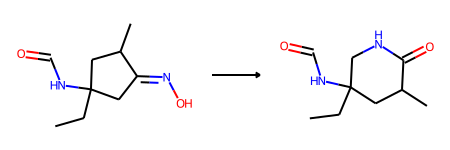

In [196]:
AllChem.ReactionFromSmarts(rxns_list[5], useSmiles = True)

In [181]:
preds_T3

['CCCc1nocn1C1CC1O',
 'CCC(C)c1ccc(N)nc1',
 'CCC(C)(C)C1(NC=O)CC1N',
 'CC(C)CC1(NC=O)CCC1N',
 'CC(C)[C@H](CC=O)NC=O',
 'CCC1(NC=O)CC(N)C(C)C1',
 'CC(C)N(C=O)C1CCC(N)C1',
 'CNC(=N)CC1(C)CCC1C',
 'CC1C2CCC3CC(N)N1C=O',
 'C#CC(C)Cc1ncon1',
 'CC(N)CCCC(C)(C)NC=O',
 'CC1CC2(C)CC(N)N(C=O)C12',
 'CN(C=O)C1(C)CCCC(N)C1',
 'CCC(N)(CC)CC(C)(CC)N',
 'CC1(C)CCC(N)C1(C)NC=O',
 'CCCC1(CC(N)C=O)CO1',
 'CCc1ncc(CCC=O)n1O',
 'CCC1(NC=O)C(N)CC1(C)C',
 'CC(N)CC1CCC(C)N1C=O',
 'CCCCC(=NO)CCNC=O',
 'CC1(C)CC(N)CCC1NC=O',
 'CCCCc1cc(C)ncn1']

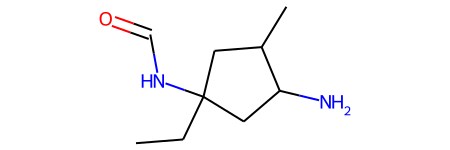

In [197]:
Chem.MolFromSmiles(preds_T3[5])

For forward tag forward validation

In [201]:
preds_T3_FT, probs_T3_FT = bw.run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3_FT, beam_size = 3, batch_size = 64, untokenize_output = True)

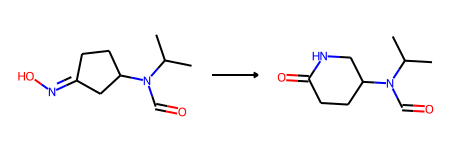

In [204]:
AllChem.ReactionFromSmarts(rxns_list[6], useSmiles = True)

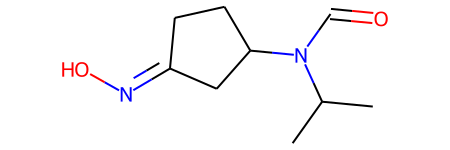

In [205]:
Chem.MolFromSmiles(preds_T3_FT[6])

input data for the forward tag T3 is: tagged ! + tokenized reactants > tagged ! + tokenized product

In [212]:
#map reactants and products
from ttlretro.single_step_retro import SingleStepRetrosynthesis
singlestepretrosynthesis = SingleStepRetrosynthesis()
MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [222]:
#tag reactants and products
#tag reactants
taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#tag products
#taggedproducts = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = False).split('>>')[1] for i in range(len(MappedReactions))]

In [233]:
reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]

In [235]:
reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]

In [236]:
reconstructed_rxns_tok

['C C C ! C ! ( = N ! O ! ) O C 1 C C 1 N C = O > C C ( = O ) O . C C ( = O ) [O-] . C C O C ( C ) = O . O . [Na+]',
 'C C C ( C ) C # C C ! C ! ( = N ! O ! ) N C = O > C C O . Cl . O . O = C ( [O-] ) [O-] . [K+]',
 'C C C ( C ) ( C ) C 1 ( N C = O ) C ! C ! 1 = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C ( C ) C C 1 ( N C = O ) C C ! C ! 1 = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C ! O ! C ! ( C ! C ( N C = O ) C ( C ) C ) = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C C 1 ( N C = O ) C ! C ! ( = N ! O ! ) C ( C ) C 1 > C C ( = O ) O . O = [Pt] = O',
 'C C ( C ) N ( C = O ) C 1 C C C ! ( = N ! O ! ) C ! 1 > C C ( = O ) O . O . [Zn]',
 'C C 1 C C C 1 ( C ) C ! C ! ( = N ! O ! ) N C ! = O ! > C C ( = O ) O . O . [Zn]',
 'C C 1 C 2 C C C 2 C ! C ! ( = N ! O ! ) N 1 C = O > C C ( = O ) O . O . [Zn]',
 'C # C C ( C ) C ! C ! ( = N ! O ! ) N ( C = O ) C C > C C O . O . [K+] . [OH-]',
 'C C ! ( C ! C C C ( C ) ( C ) N C = O ) = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C 1 C C 2 ( C ) C ! C ! ( 

In [253]:
preds_T3_FT, probs_T3_FT = run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3_FT, beam_size = 3, batch_size = 64, untokenize_output = True)
ind_match = find_ind_match_T3_preds_ref(preds_T3_FT, rxns_list)
rxns_conf = keeps_match_confident_rxns(rxns_list, probs_T3_FT, ind_match, conf_score = 0.9)
rxns_conf

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

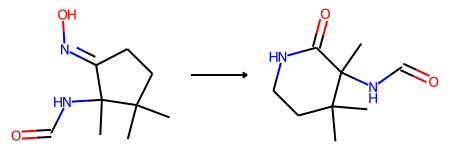

In [255]:
AllChem.ReactionFromSmarts(rxns_conf[1], useSmiles = True)

compare rxns_list expectations and forward tag 

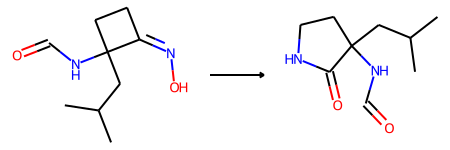

In [245]:
AllChem.ReactionFromSmarts(rxns_list[3], useSmiles = True)

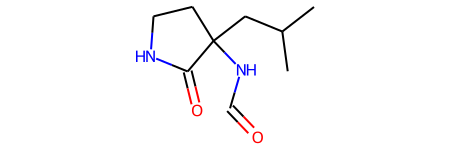

In [246]:
Chem.MolFromSmiles(preds_T3_FT[3])

In [ ]:
#rewrite new function to give the right inputs to T3
def prepare_rxns_T2_for_T3(rxns_list, preds_T2):
    
    MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))
    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
    reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]
    reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]
    return reconstructed_rxns_tok

### 3.2.3 Investigation on throughput of reactions

In [118]:
#GDB13S_1
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
with open(GDB13S_path, 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

In [119]:
len(GDB13S)

993942

In [120]:
#number of matches for lactame (not necessarily cyclic)
GDB13S_sub_Beckmann_path = '/home/yves/Documents/GitHub/USPTO_balance/GDB_subsets_1_Beckmann/GDB13S_sub_[C:1][N:3][CH:2]=[O:4].txt'
with open(GDB13S_sub_Beckmann_path, 'r') as f:
    GDB13S_sub_Beckmann = []
    for line in f:
        GDB13S_sub_Beckmann.append(line.split('\n')[0])

In [121]:
len(GDB13S_sub_Beckmann)

9773

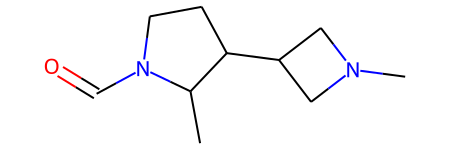

In [162]:
GDB13S_sub_mol[3003]

In [145]:
#number of created reactions for Beckmann rearrangements
created_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/created_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(created_Beckmann_reactions_path, 'r') as f:
    created_Beckmann_reactions = []
    for line in f:
        created_Beckmann_reactions.append(line.split('\n')[0])

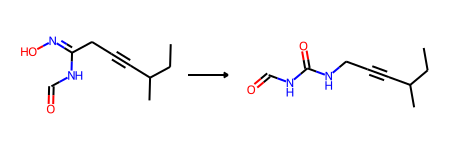

In [158]:
AllChem.ReactionFromSmarts(created_Beckmann_reactions[1], useSmiles = True)

In [123]:
len(created_Beckmann_reactions)

22

In [277]:
#number of validated Beckmann rearrangements
validated_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/saved_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(validated_Beckmann_reactions_path, 'r') as f:
    validated_Beckmann_reactions = []
    for line in f:
        validated_Beckmann_reactions.append(line.split('\n')[0])

In [268]:
len(validated_Beckmann_reactions)

2

In [278]:
validated_Beckmann_reactions

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

In [283]:
#number of validated Beckmann rearrangements limited to 10000 reactions
lines_number = 10000
validated_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/saved_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(validated_Beckmann_reactions_path, 'r') as f:
    validated_Beckmann_reactions = []
    validated_Beckmann_reactions = list(islice(f, lines_number))
    validated_Beckmann_reactions = [validated_Beckmann_reactions[i].split('\n')[0] for i in range(len(validated_Beckmann_reactions))]

In [284]:
validated_Beckmann_reactions

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

## 3.3 Standardize the call of config files with template_version / GDB_version throughout all the parts 

### 3.3.1 How is it done in part 1

In [ ]:
#config file part 1 looks like this
GDB_version = "1"
template_version = "Beckmann"
GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"

In [ ]:
#main part 1 looks like this
def main(GDB13S_path, df_templates_path_to_pkl, GDB_version, template_version):

    # Load GDB13S dataset
    with open(GDB13S_path, 'r') as f:
        GDB13S = [line.strip() for line in f]

    # Convert SMILES to RDKit molecule objects in parallel
    processes = os.cpu_count() - 2
    with Pool(processes) as p:
        output = list(tqdm(p.imap(smiles_to_mol, GDB13S), total=len(GDB13S)))
    GDB13S_mol = output

    #load df_templates prepared in (*)
    df_templates = pd.read_pickle(df_templates_path_to_pkl)

    # Extract subsets based on unique retro_reac values
    unique_retro_reac_values = df_templates['retro_reac'].unique()
    for retro_reac in unique_retro_reac_values:
        GDB13S_sub, GDB13S_sub_mol = extract_match_smiles_from_dataset(GDB13S, GDB13S_mol, retro_reac)
        convert_and_save_subset(GDB13S_sub, GDB13S_sub_mol, retro_reac, GDB_version, template_version)


### 3.3.2 How it is done in part 2

In [ ]:
#config file part 2 looks like this
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
GDB_version = "1"
template_version = "Beckmann"

In [ ]:
def main(df_templates_path, GDB_version, template_version):
    
    #load df_templates prepared in (*)
    df_templates = pd.read_pickle(df_templates_path)

    for retro_reac, retro_template in tqdm(zip(df_templates['retro_reac'], df_templates['retro_templates'])):
        process_retro_template(retro_reac, retro_template, GDB_version, template_version)


### 3.3.3 How it is done in part 3

In [ ]:
#config files part 3 look like this
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split//home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
GDB_version: "1"
template_version: "Beckmann"
Model_path_T2: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T3_Forward_255000.pt"

In [ ]:
def main(GDB_version, template_version, Model_path_T2, Model_path_T3):

    df_templates_split = load_template_version(template_version)

    for retro_reac, retro_template in tqdm(zip(df_templates_split['retro_reac'], df_templates_split['retro_templates'])):
        reactions_conf_validation(GDB_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)

def load_template_version(template_version):
    df_templates_split = pd.read_pickle(f'/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{template_version}.pkl')
    return df_templates_split


In [ ]:
#modified part 3
def main(GDB_version, df_templates_path_to_pkl, template_version, Model_path_T2, Model_path_T3):

    df_templates_split = pd.read_pickle(df_templates_path_to_pkl)

    for retro_reac, retro_template in tqdm(zip(df_templates_split['retro_reac'], df_templates_split['retro_templates'])):
        reactions_conf_validation(GDB_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)

#with commented load_template_version function

## 3.4 Check that the limit of 10000 reactions to evaluate works

In [285]:
#delete
temp1 = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_1.pkl')

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [288]:
#save only the first line of temp1 to a pkl file to test the function
temp1[1:2].to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_first_template.pkl')

In [294]:
temp1.at[0, 'retro_templates']

'([O;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(Cl-[c;H0;D3;+0:1]).([OH;D1;+0:2])'

### 3.4.1 Create config files for evaluating the first template

In [289]:
#imports to generate the config files
GDB_version = "1"
template_version = "first_template"
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl = "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_first_template.pkl"
Model_path_T2 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt"

In [290]:
#config part 1
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'w') as f:
    f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [292]:
#config file part 2
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')